<small><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/IASAC-UMH.png width="450" height="200"></small>

# <font color="steelblue">Modelos lineales de regresión para respuesta cuantitativa II</font>

**Autoría**: 

*   Fernando Borrás (f.borras@umh.es)
*   Federico Botella (federico@umh.es)
*   Inés Hernández (ines.hernandezp@umh.es)
*   Mª Asunción Martínez Mayoral (asun.mayoral@umh.es)
*   Josep Moltó (j.molto@umh.es)
*   Javier Morales (j.morales@umh.es) 

Departamento de Estadística, Matemáticas e Informática. 

Universidad Miguel Hernández de Elche. 


**Financiación**: El material que aparece a continuación se ha desarrollado dentro del marco del proyecto UNIDIGITAL- IASAC.

**Fecha última edición**: 01/03/2023

**Licencia**: <small><a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /></small>

No olvides hacer una copia si deseas utilizarlo. Al usar estos contenidos, acepta nuestros términos de uso y nuestra política de privacidad. 


# <font color="steelblue">Configuración del cuaderno</font>

Para garantizar la funcionalidad completa de este cuaderno, es preciso ejecutar la celda de código a continuación.

In [ ]:
#@title <b><font color="steelblue" size="+1"> Configuración del cuaderno
from io import StringIO 
import sys
import numpy as np      # importamos numpy como np
import pandas as pd     # importamos pandas como pd
from plotnine import *  # importamos módulo para gráficos
import math             # importamos módulo para cáculos matemáticos
import random           # importamos módulo para generadores de números aleatorios


# Esta línea configura matplotlib para mostrar las figuras incrustadas en el jupyter notebook
# Configuraciónde entorno gráfico
%matplotlib inline
import matplotlib.pyplot as plt # importamos matplotlib como plt
import seaborn as sns # importamos seaborn como sns
sns.set_style("ticks")
%config InlineBackend.figure_format = 'retina'

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

with Capturing() as output:
    print('Comenzamos....')

with Capturing(output) as output:
    # Librerías
    import os
    !pip install jupyterquiz
    from jupyterquiz import display_quiz
    import json
    import base64
    # Lectura ficheros json
    # A configurar pra cada cuaderno en función de las preguntas de autoevalaución
    for i in range(1,7):
      !wget {f"https://raw.githubusercontent.com/ia4legos/MachineLearning/main/autoeval/auto_40_{i}.json"}
    print("Cuaderno configurado")

if output[-1]=='Cuaderno configurado':
    print(output[-1])
else: 
    print(output[:-2])

Cuaderno configurado


# <font color="steelblue">Introducción</font>

**Descripción:** Introducción a los modelos lineales robustos, polinómicos y no lineales como alternativas de modelización a los modelos lineales de regresión clásicos donde se esperan relaciones lineales entre predictora y respuesta. Se muestra como usar dichos modelos para mejorar la capacidad explicativa de los modelos lineales y se aplica a diferentes casos reales.

**Nivel de Formación:** B

**Recomendaciones antes de usarlo:** Haber cursado el cuaderno referido a modelos lineales de regresión y conocimientos básicos de modelización estadística.

## <font color="steelblue">Objetivos de aprendizaje</font>

*   Conocer los modelos robustos de regresión como alternativa a los modelos de regresión clasico con presencia de observaciones anómalas.
*   Aplicar los modelos polinómicos y no lineales para modelizar relaciones complejas entre predictora y respuesta.



## <font color="steelblue">Contenidos</font>

* Actualizando el modelo
* Modelos robustos
* Modelos polinómicos y modelos no lineales
* Ampliar conocimientos

## <font color="steelblue">Bancos de datos</font>

A continuación se muestra el código para cargar los diferentes bancos de datos que utilizaremos a lo largo de este cuaderno. Entre estos encontramos `Housing` y `HousingCA`, dos de los bancos de datos tratados en el cuaderno anterior, pero esta vez ya están listos para el análisis. La descripción de las diferentes bases de datos se pueden consultar [aquí](https://colab.research.google.com/drive/1zD2LSsTpweW8fx2PNUbXT3_z3RqQMm_y?authuser=4#scrollTo=UyHNaWgG71nX).




* Housing
* HousingCA
* Electricity

In [ ]:
# Housing Dataset 
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/housing_clean.csv'
housing_clean = pd.read_csv(url)
# HousingCA Dataset 
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/housingCA_clean.csv'
housingCA_clean = pd.read_csv(url)
# Electicity Dataset 
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/mult_linear_reg.csv'
electricity = pd.read_csv(url)

# <font color="steelblue">Actualizando el modelo</font>

Una vez considerado un modelo de partida para nuestro conjunto de datos nos debemos plantear la posibilidad de mejorarlo para obtener modelos más sencillos o con mayor capacidad explicativa. 

Antes de estudiar las diferentes posibilidades de mejora que podemos plantear en los modelos lineales del cuaderno anterior, debemos generalizar algunos conceptos ya presentados para aprender sobre el efecto que tienen en la construcción de los modelos de aprendizaje. Aunque aquí presentamos los resultados para los modelos de regresión, parte de las ideas son generales en cualquier modelo de aprendizaje automático. 

En primer lugar analizamos con un poco más de profundidad los conceptos de `sesgo del modelo` (Bias) y `variabilidad del modelo` (Variance), así como su efecto sobre el error de predicción que cometemos al establecer nuestro modelo de aprendizaje. 


En la situación ideal donde tuviéramos toda la información posible de las predictoras consideradas en nuestro modelo de aprendizaje podríamos escribir:

$$y = f(X).$$

Sin embargo, ya que habitualemnte sólo disponemos de un conjunto de muestras nuestro modelo de aprendizaje lineal se expresa mediante:

$$y = f(x) + \epsilon$$

donde $\epsilon$ hace referencia al error cometido con las muestras seleccionadas, de forma que la predicción de la respuesta viene dada por:

$$\hat{y} = \hat{f}(X).$$

El sesgo del modelo es el error cometido entre el promedio de las predicciones de nuestro modelo de aprendizaje y el verdadero modelo para nuestros datos:

$$bias=E(\hat{y})- y,$$

que representa la capacidad del modelo considerado para predecir los valores de la respuesta.

La variabilidad del modelo representa la variabilidad promedio de las predicciones obtenidas para nuestro conjunto de muestras específico, es decir:

$$variance=E[(\hat{y}-E(\hat{y})^2],$$

que indica cuánto puede ajustarse el modelo considerado al cambio en el conjunto de datos que se utilizan para entrenarlo.

Esto nos lleva a la ecuación de compromiso entre sesgo y variabilidad para determinar el error del modelo que viene dado por la expresión:

$$Error = \text{sesgo}^2 + \text{variabilidad} + \text{error irreducible},$$

donde el error irreducible es aquel que no somos capaces de reducir o explicar aunque aumentemos el número de predictoras o de muestras. Dado que nuestro objetivo es quedarnos con el modelo con un error lo más pequeño posible, es evidente que tendremos que mantener un equilibrio entre sesgo y variabilidad para reducirlo.

¿cómo afectan el sesgo y la variablidad a nuestro modelo de aprendizaje?

* Un sesgo alto proporciona un modelo excesivamente simplificado, con un ajuste insuficiente, y con un alto nivel de error tanto en los datos de prueba como en los de entrenamiento.

* Una variabilidad alta proporciona un modelo excesivamente complejo, con un ajuste excesivo, y con un error bajo en los datos de entrenamiento y alto en los de prueba. En este caso interesa reducir la variabildiad de entrada (técnicas de reducción de la dimensión) antes de comenzar el proceso de modelización.

En la imagen siguiente podemos ver el efecto de los cambios en el sesgo y la variabilidiad, donde asumimos que el centro de la diana es el valor verdadero que deseamos predecir (imagen reproducida de https://www.cheatsheets.aqeel-anwar.com)

<small><center><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/img_60_10.png width="300" height="300"></center></small>

Por otro lado, en la imagen siguiente representamos el efecto que tiene el comportamiento del sesgo y la variabildiad en el ajuste del modelo. La línea gris punteada indica el punto con menos error y por tanto con mejor ajuste. En la parte izquierda tenemos el denominado modelo infra-ajustado (Under-fitting) que coincide con baja variabilidad y sesgo alto, mientras que en la parte derecha tenemos el modelo sobre-ajustado (Over-fitting) que coincide con alta variabilidad y sesgo bajo. En el mínimo error tenemos el compromiso entre sesgo y variabilidad (Just Right).

<small><center><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/img_60_20.png width="350" height="250"></center></small>

Entendemos por infra-ajuste cuando el modelo no explica bien los datos de entrenamiento (los datos que se usaron para ajustar el modelo), ni esperamos que se generalice a ningún dato no visto previamente del mismo proceso de generación de datos. El infra-ajuste suele ser el resultado de un modelo que no es lo suficientemente complejo para ajustarse a los datos dados. La forma más fácil de abordarlo es aumentando la complejidad del modelo, por ejemplo, agregando más predictoras.

El sobre-ajuste, por otro lado, es el caso en el que el modelo se ajusta muy bien a los datos de entrenamiento pero no logra generalizar sus resultados a la muestra de validación o a otro nuevo conjunto de datos. 

En el cuaderno anterior (Modelos lineales de regresión para respuesta cuantitativa I) ajustamos a las bases de datos `Housing` y `HousingCA` un modelo de regresión lineal múltiple y calculamos, entre otras cosas, el error que se comete al ajustarlo y su capacidad explicativa. A continuación, se muestra en tablas los valores de MSE, RMSE y $R^2$ para los conjuntos de entrenamiento y validación.

## Housing

Recopilando la información del modelo obtenido en el cuaderno anterior para el banco de datos de `Housing` tenemos que los indicadores del modelo para la muestra de entrenamiento y validación son:

|                 | MSE    | RMSE | $R^2$ |
|-----------------|--------|------|-------|
| Entrenamiento   | 0.256  | 0.506| 0.751 |
| Validación      | 0.288  | 0.537| 0.669 |


## HousingCA

Recopilando la información del modelo obtenido en el cuaderno anterior para el banco de datos de `HousingCA` tenemos que los indicadores del modelo para la muestra de entrenamiento y validación son:

|                 | MSE    | RMSE | $R^2$ |
|-----------------|--------|------|-------|
| Entrenamiento   | 0.364  | 0.603| 0.638 |
| Validación      | 0.378  | 0.615| 0.616 |

# <font color="steelblue">Modelos robustos</font>


Los modelos robustos tienen como objetivo ajustar un modelo de regresión en presencia de datos atípicos o incumplimiento en las hipótesis de los errores del modelo. Para poder ajustar un modelo robusto debemos importar la función [RANSACRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html#sklearn-linear-model-ransacregressor) de la clase `sklearn.linear_model`

Los parámetros básicos para la configuración de la función 
**estimator**, objeto estimador base que implementa los siguientes métodos son:
* `fit(X, y)`: ajusta el modelo a los datos de entrenamiento y a los valores objetivo.
* `score(X, y)`: devuelve la precisión media en los datos de validación.
* `predict(X)`: devuelve los valores predichos mediante el modelo lineal, que se utiliza para calcular el error residual mediante la función de pérdida.

El primer método es el que nos permite realizar el entrenamiento del modelo `fit` donde debemos especificar la matriz de predictoras y la respuesta:


```
ransac.fit(X, y)
```




El método que nos permite realizar la predicción es `predict`. Antes de poder realizarla debemos indicar entre qué valores queda definido el eje x.



```
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)
```



Además de la función comentada, existen otras dos funciones que pueden ajustar modelos robustos. Estas son [Teil Sen](https://scikit-learn.org/stable/modules/linear_model.html#theil-sen-regression) y [HuberRegressor](https://scikit-learn.org/stable/modules/linear_model.html#huber-regression).

## Ejemplo 1.2

Como ejemplo analizamos el ejemplo 1.2 del cuaderno anterior.

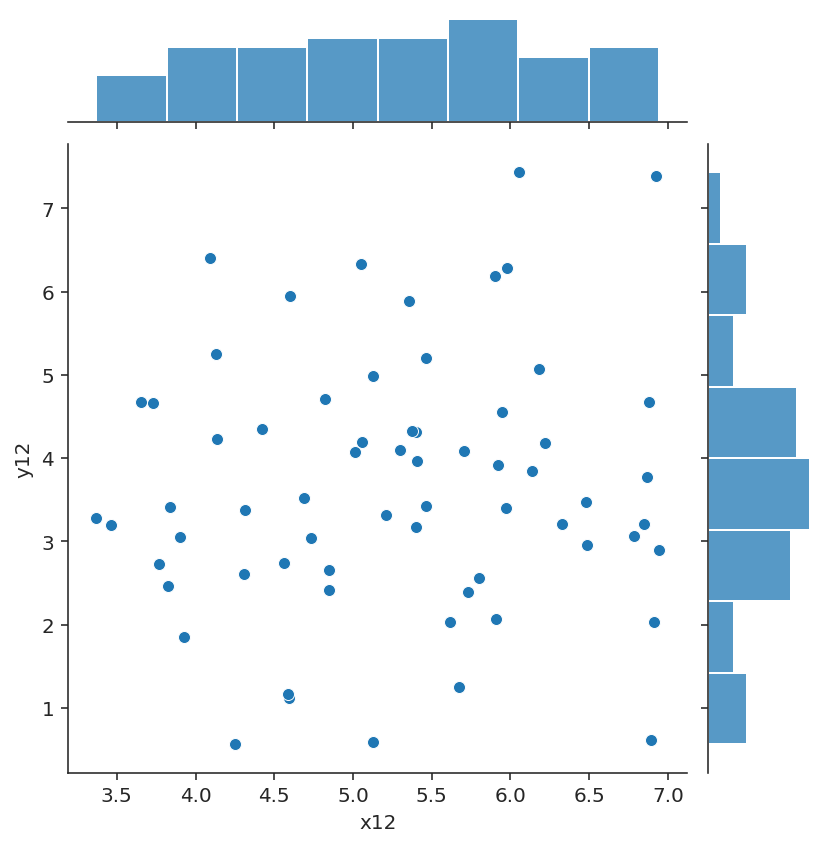

In [ ]:
# Generamos los puntos
np.random.seed(0)
mu, sigma = 0, 1.5
error = np.random.normal(mu, sigma, 65)
datos2 = pd.DataFrame()
x12 = np.random.normal(5, 1, 65)
y12 = 1 + 0.5*x12 + error
datos2['x12'] = x12
datos2['y12'] = y12
# Representamos gráficamente la nube de puntos obtenida
sns.jointplot(data=datos2, x="x12", y="y12");

No se observa una clara tendencia entre predictora y respuesta debido a la dispersión de los puntos. Por ello, procedemos a utilizar modelos robustos.

In [ ]:
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.model_selection import GridSearchCV

Obtenemos el estimador robusto:

In [ ]:
# Regresión robusta usando RANSACRegressor()
ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=30, 
                         random_state=0)

# Modificamos las dimensiones para proceder con el ajuste
x12 = x12.reshape(-1,1)
y12 = y12.reshape(-1,1)

# Ajustamos 
ransac.fit(x12, y12)
# Valores utilizados para el ajuste
inlier_mask = ransac.inlier_mask_
# Valores atípicos
outlier_mask = np.logical_not(inlier_mask)

Analizamos los parámetros del modelo robusto obtenido:

In [ ]:
# Valores de pendiente y sesgo
pendiente =  np.round(ransac.estimator_.coef_,2)
sesgo = np.round(ransac.estimator_.intercept_,2)
print(f'Sesgo: {sesgo}\nPendiente = {pendiente}')

Sesgo: [2.22]
Pendiente = [[0.24]]


El modelo resultante es:

$$y = 2.22 + 0.24 · X $$

Se caracteriza por tener un promedio de la respuesta sin la presencia de la predictora de 2.22 y un aumento del valor de la respuesta en 0.24 unidades por cada unidad que aumenta el valor de la predictora. Podemos ver además que el modelo obtenido refleja un poco mejor el modelo teórico de partida $y = 1 + 0.5*X$ que el lineal obtenido en el capítulo anterior. 

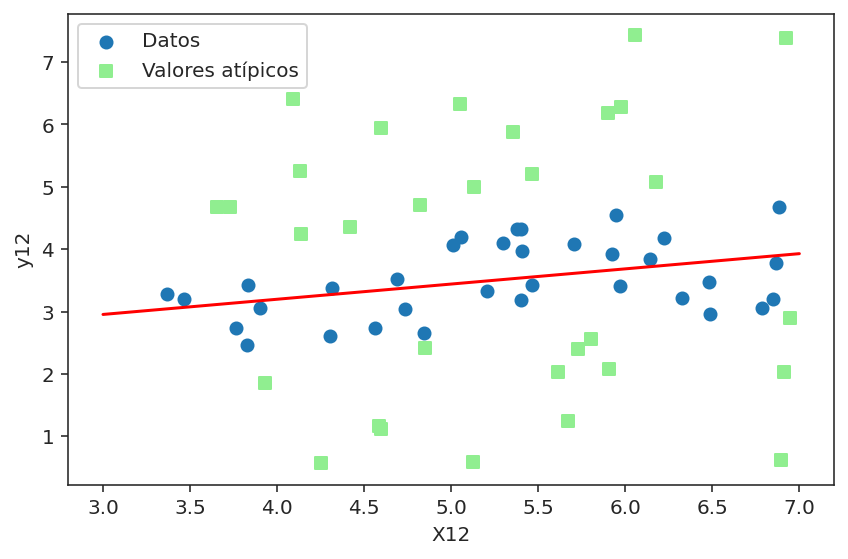

In [ ]:
# Graficamos los datos y el ajuste con RANSAC
# IDentificamos los puntos utilizados en ajuste y los no utilizados (atípicos)
line_X = np.arange(3, 8, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(x12[inlier_mask], y12[inlier_mask], marker='o', label='Datos')
plt.scatter(x12[outlier_mask], y12[outlier_mask], c='lightgreen', marker='s', label='Valores atípicos')
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('X12')
plt.ylabel('y12')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Predicción del modelo robusto
y_lin_pred = ransac.predict(x12)

# Cálculo MSE
print('MSE : %.3f' % (
        round(mean_squared_error(y12, y_lin_pred),2)))

MSE : 2.390


En el cuaderno anterior ajustamos un modelo de regresión lineal y obtuvimos un valor de MSE de 3.34. Ajustando el modelo robusto obtenemos un valor de MSE de 2.39 y por lo tanto, ajustando el modelo robusto obtenemos mejores predicciones que haciéndolo con el modelo de regresión lineal.

# <font color="steelblue">Modelos polinómicos y Modelos no lineales</font>


La regresión polinomial pertenece a la misma clase que los modelos lineales que consideramos en capítulos anteriores  y se puede resolver con las mismas técnicas. Al considerar los ajustes lineales dentro de un espacio de mayor dimensión construido con estas funciones básicas, el modelo tiene la flexibilidad de adaptarse a una gama de datos mucho más amplia. Los modelos polinómicos plantean relaciones basadas en polininomios de diferentes grados para la relación entre predictora y respuesta cuando la relación observada entre ellas no es de tipo lineal. Por ejemplo, el modelo polinómico de grado 2 nos permite establecer relaciones de tipo parabólico entre respuesta y predictora:

$$y = \beta_0 + \beta_1 x + \beta_2 x^2$$

La función necesaria para realizar un ajuste polinómico es [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). Los parámetros de esta función son:
* `degree`: indica el grado del polinomio.
* `interaction_only`: si es `True` se excluyen los términos con una potencia de 2 o más de la misma característica de entrada.
* `include_bias`: si es `True` incluye una columna de sesgo, la característica en la que todas las potencias polinómicas son cero.
* `order`: orden de la matriz de salida. 

A continuación mostramos como usar estas funciones en diferentes ejemplos, analizando como varía la calidad del modelo al introducir dichos efectos polinómicos.

## Ejemplo 1.3

A continuación, vamos a ajustar un modelo polinómico al ejemplo 1.3 que vimos en el cuaderno anterior. Dado que nuestro modelo teórico no es una recta esperamos que un  modelo polinómico flexible proporcione buenos resultados. En primer lugar realizamos el gráfico de dispersión de los datos.

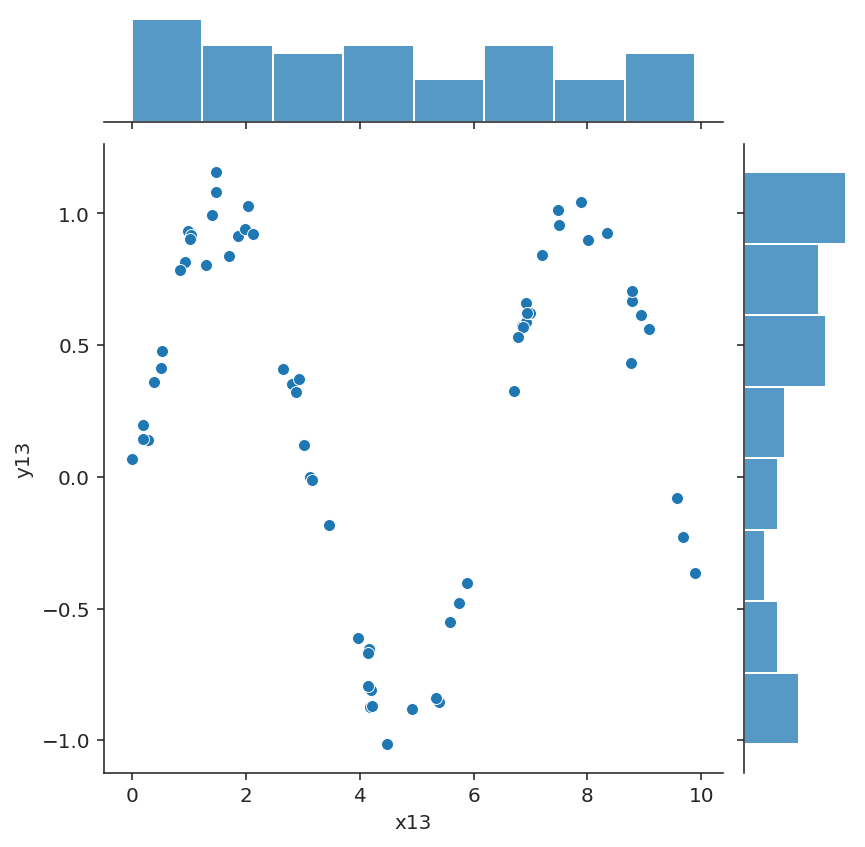

In [ ]:
# Generamos los puntos
np.random.seed(0)
rng = np.random.RandomState(1)
x13 = 10 * rng.rand(65)
y13 = np.sin(x13) + 0.1 * rng.randn(65)
datos3 = pd.DataFrame()
datos3['x13'] = x13
datos3['y13'] = y13
# Representamos gráficamente la nube de puntos obtenida
sns.jointplot(data=datos3, x="x13", y="y13");

Para comenzar vamos a ajustar manualmente cuatro modelos diferentes: lineal, de grado 2, de grado 3 y de grado 4. De este modo podremos comparar la bondad del ajuste de todos los modelos polinómicos frente al que obtuvimos en el cuaderno anterior. De esta forma optaremos por aquel que proporcione un mejor ajuste.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

Ajustamos diferentes modelos polinómicos (desde el lineal hasta el grado 4) y analizamos la calidad de los ajustes obtenidos.

In [ ]:
# Ajuste modelo polinómico grado 1 (lineal)
lr = LinearRegression()
# Modificar dimensión
x13 = x13.reshape(-1,1)
# Ajustar características lineales
lr.fit(x13, y13)
X_fit = np.arange(0,10,0.5)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [ ]:
# Ajuste modelo polinómico grado 2
pr = LinearRegression()
cuadratico = PolynomialFeatures(degree=2)
# Ajustar y estandarizar
X_quad = cuadratico.fit_transform(x13)
# Ajustar características cuadráticas
pr.fit(X_quad, y13)
y_quad_fit = pr.predict(cuadratico.fit_transform(X_fit))

In [ ]:
# Ajuste modelo polinómico grado 3
pr3 = LinearRegression()
gr3 = PolynomialFeatures(degree = 3)
X_gr3 = gr3.fit_transform(x13)
# Ajustar características de grado 3
pr3.fit(X_gr3, y13)
y_gr3_fit = pr3.predict(gr3.fit_transform(X_fit))

In [ ]:
# Ajuste modelo polinómico grado 4
pr4 = LinearRegression()
gr4 = PolynomialFeatures(degree = 4)
X_gr4 = gr4.fit_transform(x13)
# Ajustar características de grado 4
pr4.fit(X_gr4, y13)
y_gr4_fit = pr4.predict(gr4.fit_transform(X_fit))

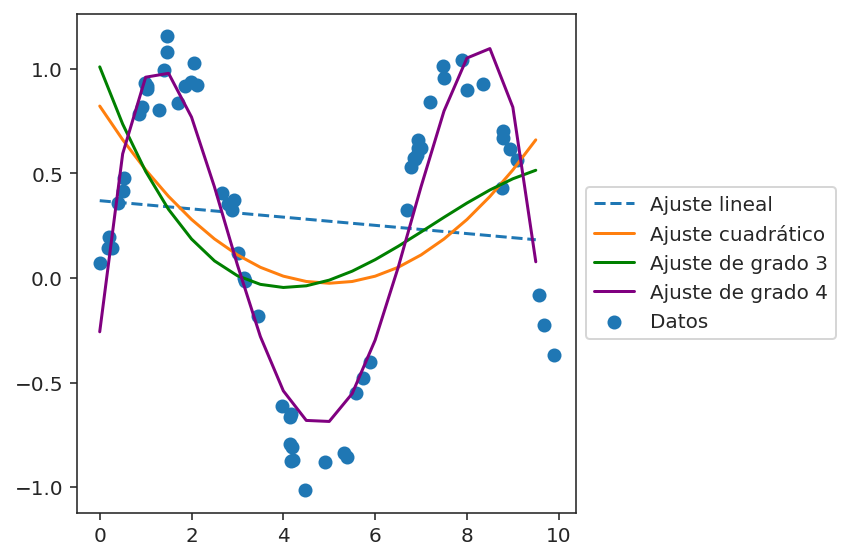

In [ ]:
# Graficar los diferentes modelos obtenidos
plt.scatter(x13, y13, label='Datos')
plt.plot(X_fit, y_lin_fit, label='Ajuste lineal', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Ajuste cuadrático')
plt.plot(X_fit, y_gr3_fit, label='Ajuste de grado 3', color = 'green')
plt.plot(X_fit, y_gr4_fit, label='Ajuste de grado 4', color = 'purple')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

En el gráfico obtenido se puede observar que el modelo polinómico de grado 4 evidentemente es el que tiene un mejor ajuste al conjunto de entrenamiento ya que es capaz de reproducir la tendencia de los datos de forma más realista. Obtenemos las predicciones y los correspondientes MSE y $R^2$ para los modelos ajustados.

In [ ]:
# Predicciones
y_lin_pred = lr.predict(x13)
y_quad_pred = pr.predict(X_quad)
y_gr3_pred = pr3.predict(X_gr3)
y_gr4_pred = pr4.predict(X_gr4)

In [ ]:
# Valoración del modelo: MSE y R^2
print('MSE de los datos de entrenamiento lineales: %.3f, cuadráticos: %.3f, grado 3: %.3f, grado 4: %.3f' % (
        mean_squared_error(y13, y_lin_pred),
        mean_squared_error(y13, y_quad_pred),
        mean_squared_error(y13, y_gr3_pred),
        mean_squared_error(y13, y_gr4_pred)))
print(' R^2 de los datos de entrenamiento lineales: %.3f, cuadráticos: %.3f, grado 3: %.3f, grado 4: %.3f' % (
        r2_score(y13, y_lin_pred),
        r2_score(y13, y_quad_pred),
        r2_score(y13, y_gr3_pred),
        r2_score(y13, y_gr4_pred)))

MSE de los datos de entrenamiento lineales: 0.401, cuadráticos: 0.337, grado 3: 0.329, grado 4: 0.040
 R^2 de los datos de entrenamiento lineales: 0.008, cuadráticos: 0.165, grado 3: 0.186, grado 4: 0.900


El modelo que mejor se ajusta es el de grado 4 ya que tiene un valor de MSE de tan solo 0.04 y un $R^2$ de 0.9. El 90% de la variabilidad total de la respuesta es explicada por el modelo obtenido, es decir, la variable predictora tiene mucha capacidad para indicar el comportamiento de la respuesta.

## Ejemplo 1.3 bis

Es evidente que la elección del grado del polinomio que debemos utilizar es una tarea relevante que debe automatizarse para no hacer una búsqueda manual. Volvemos a ajustar el ejemplo 1.3 pero en este caso vamos a buscar el grado del polinomio óptimo mediante el uso de un bucle que nos permite obtener el mejor grado a partir de una lista de valores predefinidos.

En concreto establecemos como posibles grados del modelo polinómico los valores del 1 a 9.

In [ ]:
from sklearn.model_selection import cross_val_score 

# Reajustamos la dimensión
x13 = x13.reshape(-1,1)
# Establecemos los posibles grados del modelo polinómico
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9] 
best_score = 0
best_degree = 0
graf = []
mse = []

# Bucle de búsqueda del mejor modelo con el score correspondiente
for degree in degrees:
    poly_features = PolynomialFeatures(degree = degree)
    X13_poly = poly_features.fit_transform(x13)
    polynomial_regressor = LinearRegression()
    polynomial_regressor.fit(X13_poly, y13)
    scores = cross_val_score(polynomial_regressor, X13_poly, y13) 
    y13_pred = polynomial_regressor.predict(X13_poly)
    r2 = r2_score(y13, y13_pred)
    graf.append(r2)
    error = mean_squared_error(y13, y13_pred)
    mse.append(error)
    if max(scores) > best_score:
        best_score = max(scores)
        best_mse = r2_score(y13, y13_pred)
        best_degree = degree
        reg = polynomial_regressor


Representamos gráficamente la evolución del MSE y $R^2$ en función del grado del polinomio ajustado.

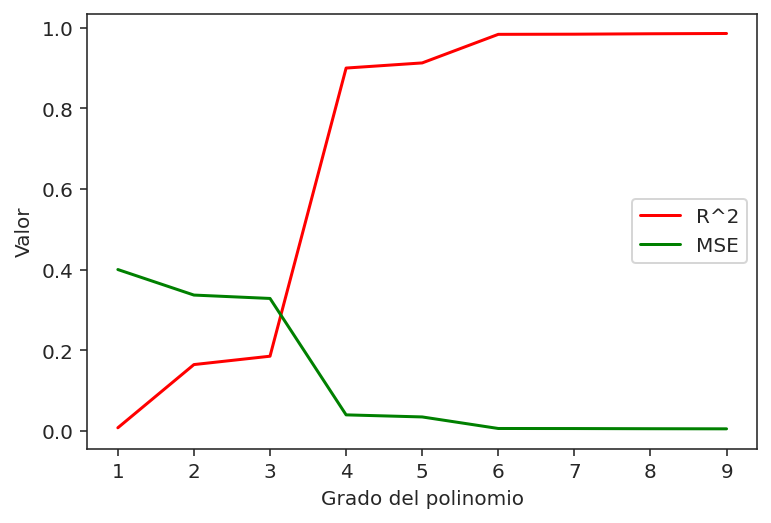

In [ ]:
fig, ax = plt.subplots()
ax.plot(degrees, graf, color = 'red', label = 'R^2')
ax.plot(degrees, mse, color = 'green', label = 'MSE')
plt.xlabel('Grado del polinomio')
plt.ylabel('Valor')
plt.legend(loc='center right')
plt.show()

In [ ]:
print('El grado del polinomio óptimo es: %.3f' % (
    best_degree))
print('Validación cruzada: %.3f' % (
    round(best_score,3)))

El grado del polinomio óptimo es: 7.000
Validación cruzada: 0.992


Como podemos observar, el polinomio que mejor se ajusta a nuestro conjunto de datos según el resultado analítico es es el de grado 7 ya que tiene un valor de 0.99 en la validación cruzada. Sin embargo, si nos fijamos en el gráfico de la evolución del $R^2$ en función del grado del polinomio podemos observar que a partir de un polinomio de grado 4 ya tenemos un valor de $R^2$ superior al 0.8 y un error bastante próximo a 0, por lo tanto, nuestro modelo ya es capaz de ajustarse manera adecuada a los datos. Como explicábamos al principio del cuaderno, a veces se produce un sobreajuste de modo que el modelo a posteriori no será capaz de generalizar. En este caso utilizar el grado 7 nos puede llevar a ese sobreajuste y se puede optar por utilizar el grado 4, dado que sus medidas de calidad son suficientes.

Ajustamos el nuevo modelo:

In [ ]:
# Ajuste modelo polinómico grado 4
X_fit = np.arange(0,10,0.5)[:, np.newaxis]

pr4 = LinearRegression()
gr4 = PolynomialFeatures(degree = 4)
X_gr4 = gr4.fit_transform(x13)
# Ajustar características de grado 4
pr4.fit(X_gr4, y13)
y_gr4_fit = pr4.predict(gr4.fit_transform(X_fit))

In [ ]:
y13 = y13.reshape(-1,1)
data = pd.DataFrame({'x13': x13[:,0]})

# Obtenemos los  coeficientes del modelo
dfPoly = pd.DataFrame(
    data=gr4.fit_transform(data), 
    columns=gr4.get_feature_names(data.columns))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [ ]:
round(dfPoly.head(1),3)

,1,x13,x13^2,x13^3,x13^4
0,1.0,4.17,17.391,72.523,302.438


El modelo tiene por ecuación:
$$\widehat y = 4.170x+17.391x^2+72.523x^3+302.438x^4$$

Representamos gráficamente el modelo ajustado.

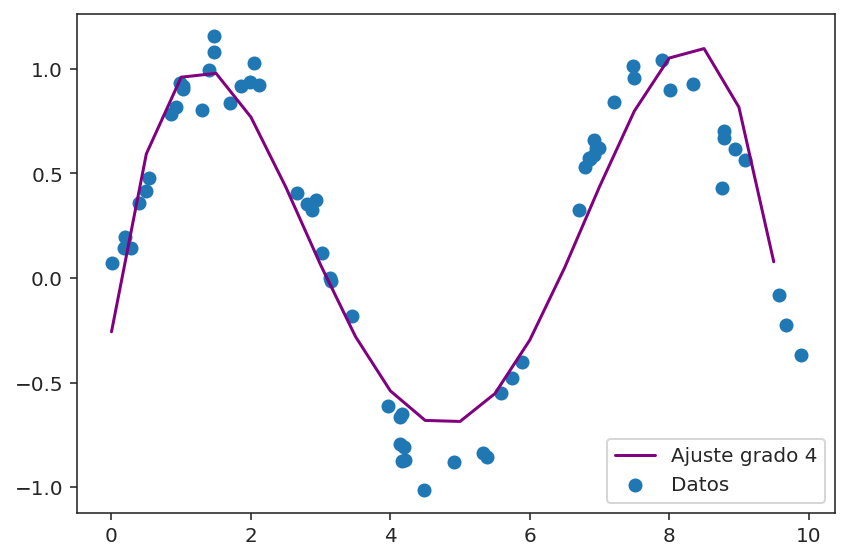

In [ ]:
# Ajustar
reg.fit(X_gr4, y13)
y_mod_fit = reg.predict(gr4.fit_transform(X_fit))

# Gráfico
plt.scatter(x13, y13, label='Datos')
plt.plot(X_fit, y_mod_fit, label='Ajuste grado 4', color = 'purple')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

Obtenemos las medidas de calidad del ajuste:

In [ ]:
# Calcular MSE
y_gr4_pred = reg.predict(X_gr4)
print('MSE: %.3f' % (
        mean_squared_error(y13, y_gr4_pred)))
# Calcular R^2
print(' R^2: %.3f' % (
        r2_score(y13, y_gr4_pred)))

MSE: 0.040
 R^2: 0.900


Obtenemos la medida de bondad de ajuste del modelo polinómico de grado 4 que, como era de esperar, coincide con la del ejemplo 1.3 . El modelo tiene un valor de $R^2$ de 90% por lo que la variable predictora explica muy bien el comportamiento de la respuesta.

## Electricity

Ajustamos un modelo polinómico  al conjunto de datos `electricity`.

In [ ]:
# Nombre variables
electricity.columns.values

array(['AT', 'V', 'AP', 'RH', 'PE'], dtype=object)

En primer lugar, obtenemos un diagrama de dispersión de cada una de las predictoras con la variable objetivo. 

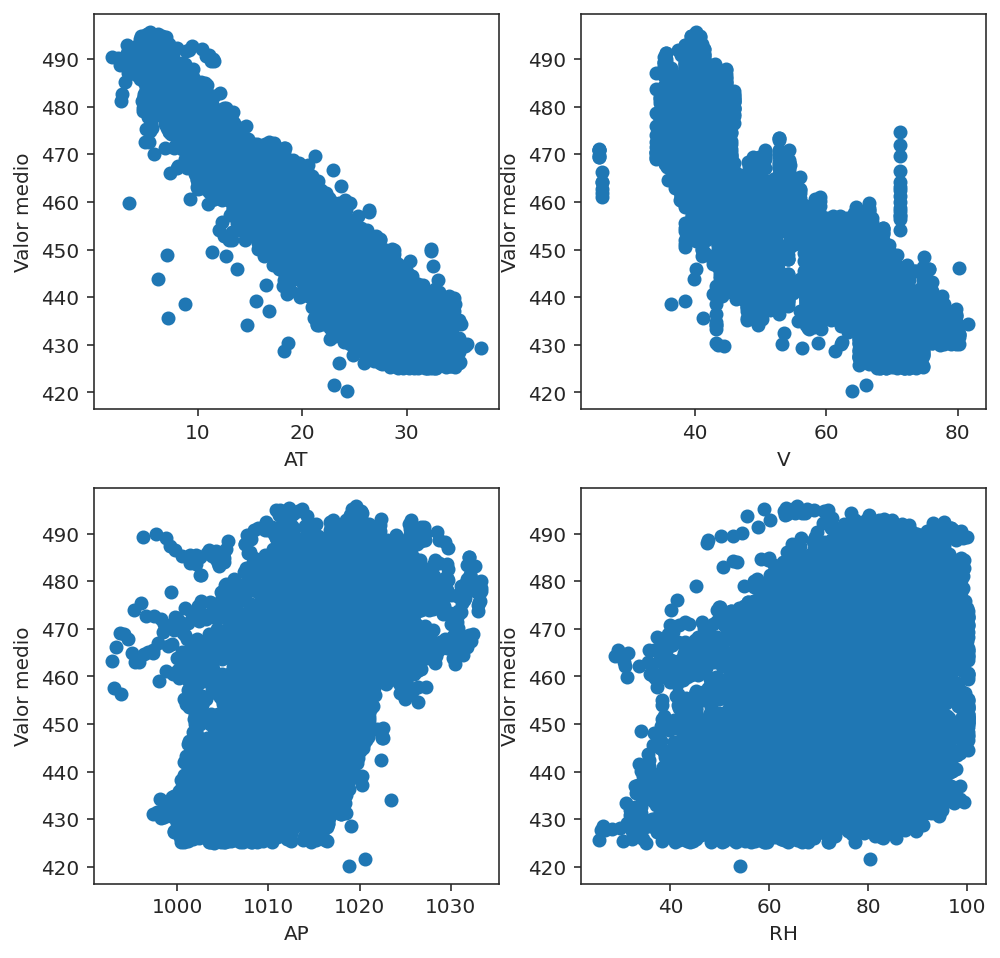

In [ ]:
# Seleccionamos las variables
variables = ['AT', 'V', 'AP', 'RH']
# Creamos el gráfico de disersión correspondiente
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))  
j=0
for i in range(2):
  for p in range(2):
    ax[i,p].scatter(x=variables[j], y='PE', data = electricity)
    ax[i,p].set(ylabel='Valor medio')
    ax[i,p].set(xlabel=variables[j])
    j=j+1  
plt.show()

Observando los diagramas de dispersión, podemos deducir que la variable `EP` tiene una relación lineal con `AT` y una polinomial con `V`. Con las otras dos variables no se puede deducir a simple vista ya que los puntos tienen una gran variabilidad.

Construímos un modelo donde consideramos Vacío de Escape (V) como la única predictora considerando la posibilidad de construir un modelo polinómico.

In [ ]:
# Asignar
y3 = electricity['PE']
X3 = electricity['V']

Una vez definidas la variable objetivo y la predictora convertimos la predictora en array para poder modificar fácilmente su dimensión.

In [ ]:
# Convertir variables en arrays
X3 = np.array(X3)
y3 = np.array(y3)

Buscamos el polinomio que mejor se ajusta a nuestros datos. Establecemos como posibles grados del modelo polinómico los valores del 1 al 6.

In [ ]:
from ctypes import memset
# Reajustamos la dimensión
X3 = X3.reshape(-1,1)
# Establecemos los posibles grados del modelo polinómico
degrees = [1, 2, 3, 4, 5, 6] 
best_score = 0
best_degree = 0
graf = []
mse = []
# Bucle de búsqueda del mejor modelo con el score correspondiente
for degree in degrees:
    poly_features = PolynomialFeatures(degree = degree)
    X3_poly = poly_features.fit_transform(X3)
    polynomial_regressor = LinearRegression()
    polynomial_regressor.fit(X3_poly, y3)
    scores = cross_val_score(polynomial_regressor, X3_poly, y3)
    y3_pred = polynomial_regressor.predict(X3_poly) 
    r2 = r2_score(y3, y3_pred)
    graf.append(r2)
    error = mean_squared_error(y3, y3_pred)
    mse.append(error)
    if max(scores) > best_score:
        best_score = max(scores)
        best_degree = degree
        reg = polynomial_regressor

Obtenemos el mejor grado del polinomio

In [ ]:
print('El grado del polinomio óptimo es: %.3f' % (
    best_degree))
print('Validación cruzada: %.3f' % (
    round(best_score,3)))

El grado del polinomio óptimo es: 6.000
Validación cruzada: 0.792


Analíticamente obtenemos que el polinomio que mejor se ajusta a nuestro conjunto de datos es el de grado 6 pero, como hemos podido observar en ejemplos anteriores, a veces se produce un sobreajuste. Para observar la evolución de la capacidad explicativa de cada modelo realizamos el siguiente gráfico.

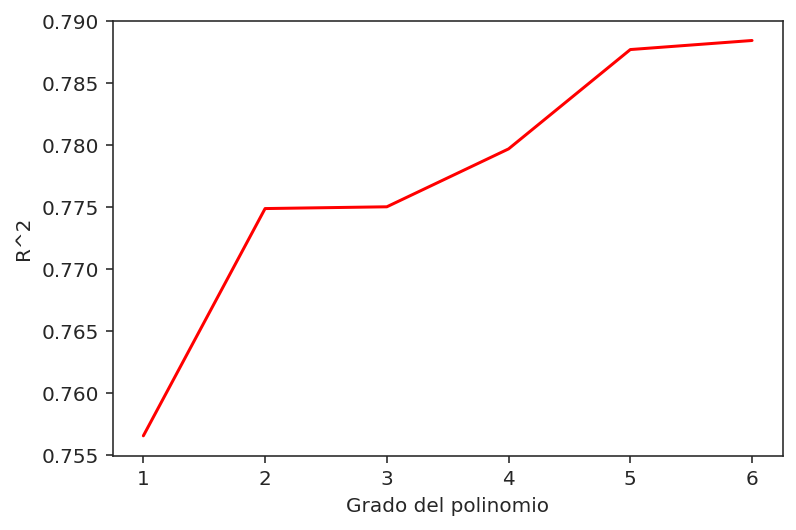

In [ ]:
fig, ax = plt.subplots()
ax.plot(degrees, graf, color = 'red')
plt.xlabel('Grado del polinomio')
plt.ylabel('R^2')
plt.show()

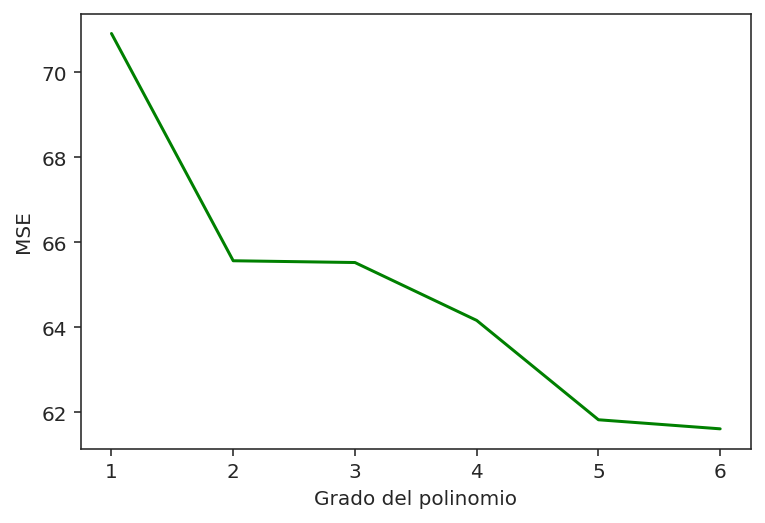

In [ ]:
fig, ax = plt.subplots()
ax.plot(degrees, mse, color = 'green')
plt.xlabel('Grado del polinomio')
plt.ylabel('MSE')
plt.show()

Efectivamente, el modelo de grado 6 está sobreajustado. En este caso decidimos escoger el modelo de grado 2 porque se ajustará mejor a nuestros datos.

In [ ]:
# Ajuste modelo polinómico grado 2
X_fit = np.arange(25,85,0.5)[:, np.newaxis]

pr2 = LinearRegression()
gr2 = PolynomialFeatures(degree=2)
# Ajustar y estandarizar
X_gr2 = gr2.fit_transform(X3)
# Ajustar
pr2.fit(X_gr2, y3)
y3_gr2_fit = pr2.predict(gr2.fit_transform(X_fit))

In [ ]:
y3 = y3.reshape(-1,1)
data = pd.DataFrame({'X': X3[:,0]})

# Obtenemos los  coeficientes del modelo
dfPoly = pd.DataFrame(
    data=gr2.fit_transform(data), 
    columns=gr2.get_feature_names(data.columns));

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [ ]:
round(dfPoly.head(1),3)

,1,X,X^2
0,1.0,41.76,1743.898


El modelo tiene por ecuación:
$$\widehat{y} = 1 + 41.76x+1743.898x^2$$

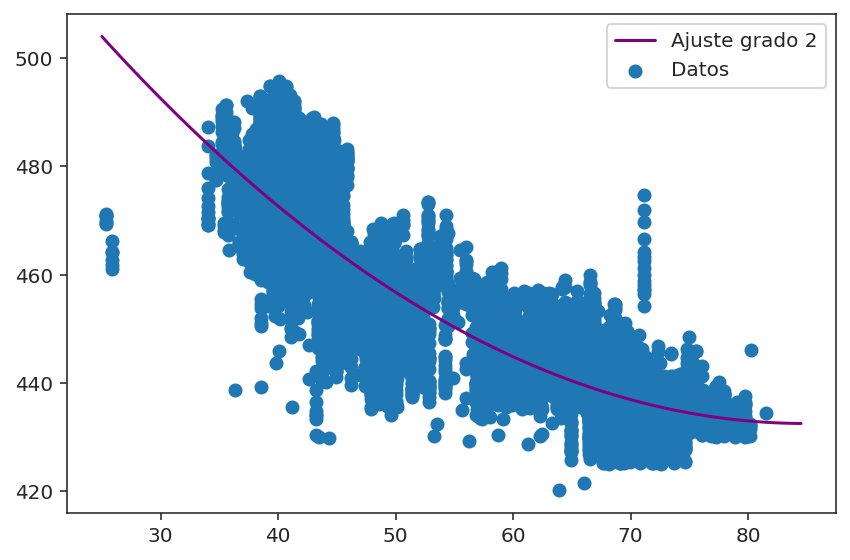

In [ ]:
# Ajustar
reg.fit(X_gr2, y3)
y_gr2_fit = reg.predict(gr2.fit_transform(X_fit))
# Gráfico
plt.scatter(X3, y3, label='Datos')
plt.plot(X_fit, y_gr2_fit, label='Ajuste grado 2', color = 'purple')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Gráficamente podemos observar que el ajuste de grado 2 capta bastante bien el comportamiento del modelo y parece tener una buena capacidad explicativa. A continuación calculamos su valor de MSE.

In [ ]:
# Calcular MSE
y_gr2_pred = reg.predict(X_gr2)
print('MSE del modelo de grado 2: %.3f' % (
        mean_squared_error(y3, y_gr2_pred)))
# Calcular R^2
print(' R^2 del modelo de grado 2: %.3f' % (
        r2_score(y3, y_gr2_pred)))

MSE del modelo de grado 2: 65.567
 R^2 del modelo de grado 2: 0.775


El $R^2$ es 0.775, indica que el modelo explica el 77.5% de la variabilidad de la respuesta pero no nos fijamos en este ya que no es útil cuando tenemos estructuras o modelos cuya tendencia no es lineal. La tendencia que estamos analizando es cuadrática, por eso nos fijamos en el valor de MSE de 65.567.

Una vez obtenido el modelo polinómico procedemos a calcular el ajuste del modelo lineal para observar si se ha producido una mejora o no y la magnitud de esta.

In [ ]:
# Ajuste modelo lineal
lr = LinearRegression()
# Ajustar características lineales
lr.fit(X3, y3)

LinearRegression()

In [ ]:
# Valor de predicción
y3_pred = lr.predict(X3)
# valor de R2
print('R^2 del modelo lineal: %.3f' % (
        r2_score(y3, y3_pred)))
# valor de MSE
print('MSE del modelo lineal: %.3f' % (
        mean_squared_error(y3, y3_pred)))

R^2 del modelo lineal: 0.757
MSE del modelo lineal: 70.915


Observando los resultados obtenidos, el valor del MSE pasa de ser, ajustando el modelo lineal 70.92, a 65.57 ajustando el modelo cuadrático. En este caso como se observa una clara tendencia cuadrática de manera gráfica y no hay sobreajuste, el modelo cuadrático será mejor opción a la hora de escoger un modelo que se ajuste a nuestros datos.

Por lo tanto, para predecir la producción de energía eléctrica neta por hora (`PE`) de la planta en función de la variable Vacío de Escape (`V`) el modelo óptimo es uno polinómico de grado 2. 

## Housing

En el cuaderno anterior observamos como en el ejemplo de la base de datos `Housing` algunas de las variables predictoras parecían tener una asociación cuadrática con la respuesta. El comportamiento de las variables se muestra a continuación gráficamente. Cabe destacar por su asociación no lineal las variables `INDUS`, `LSTAT`, `NOX` y `TAX`.

<center><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/img_60_30.png width="600" height="400"></center>

Pra ajustar el modelo consideramos como nuevas variables predictoras las originales elevadas al cuadrado para captar las posibles tendencias parabólicas observadas en los gráficos. 

In [ ]:
# Asignamos los datos
y2 = housing_clean['MEDV']
X2 = housing_clean.drop(columns=['MEDV'])

Añadimos el efecto de las variables INDUS, LSTAT, NOX y TAX elevadas al cuadrado al conjunto X2.

In [ ]:
X2.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.000735,0.772552,0.337051,0.0,4.647422,9.367131,2.318549,1.944260,0.114960,1.758028,7.074146,4.351754,0.698065
1,0.003178,0.000000,1.031579,0.0,4.051377,9.147733,2.805729,2.361206,0.229921,1.437306,8.230052,4.351754,1.281188
2,0.003176,0.000000,1.031579,0.0,4.051377,10.236173,2.172751,2.361206,0.229921,1.437306,8.230052,4.307129,0.564900
3,0.003767,0.000000,0.318082,0.0,3.956355,9.969761,1.628674,2.881783,0.344881,1.318521,8.646179,4.326865,0.412111
4,0.008036,0.000000,0.318082,0.0,3.956355,10.182036,1.927383,2.881783,0.344881,1.318521,8.646179,4.351754,0.747126


Construímos las variables al cuadrado para el ajuste del modelo polinómico.

In [ ]:
X2[1] = X2.insert(len(X2.columns),'INDUS2',housing_clean['INDUS']*housing_clean['INDUS'])
X2[1] = X2.insert(len(X2.columns),'LSTAT2',housing_clean['LSTAT']*housing_clean['LSTAT'])
X2[1] = X2.insert(len(X2.columns),'NOX2',housing_clean['NOX']*housing_clean['NOX'])
X2[1] = X2.insert(len(X2.columns),'TAX2',housing_clean['TAX']*housing_clean['TAX'])

In [ ]:
X2 = X2.drop(columns=[1])

In [ ]:
X2.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,INDUS2,LSTAT2,NOX2,TAX2
0,0.000735,0.772552,0.337051,0.0,4.647422,9.367131,2.318549,1.944260,0.114960,1.758028,7.074146,4.351754,0.698065,0.113603,0.487295,21.598527,3.090662
1,0.003178,0.000000,1.031579,0.0,4.051377,9.147733,2.805729,2.361206,0.229921,1.437306,8.230052,4.351754,1.281188,1.064155,1.641444,16.413654,2.065850
2,0.003176,0.000000,1.031579,0.0,4.051377,10.236173,2.172751,2.361206,0.229921,1.437306,8.230052,4.307129,0.564900,1.064155,0.319112,16.413654,2.065850
3,0.003767,0.000000,0.318082,0.0,3.956355,9.969761,1.628674,2.881783,0.344881,1.318521,8.646179,4.326865,0.412111,0.101176,0.169835,15.652746,1.738497
4,0.008036,0.000000,0.318082,0.0,3.956355,10.182036,1.927383,2.881783,0.344881,1.318521,8.646179,4.351754,0.747126,0.101176,0.558198,15.652746,1.738497


Una vez añadidas las variables que hemos seleccionado elevadas al cuadrado, dividimos la base de datos en conjunto de entrenamiento y validación.

In [ ]:
from sklearn.model_selection import train_test_split
# División de muestras^2 normalizadas
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=42)

Ajustamos un modelo lineal múltiple añadiendo el efecto de las variables INDUS, LSTAT, NOX y TAX elevadas al cuadrado.

In [ ]:
# Planteamos el modelo
lr = LinearRegression()
# Entrenamos el modelo
lr.fit(X2_train, y2_train)
# Obtenemos los pesos o coeficientes del modelo
np.round(lr.intercept_,3)

3.351

Obtenemos los coeficientes del modelo que mejor se ajusta a nuestros datos.

In [ ]:
# Matriz de pesos
pd.DataFrame(np.round(lr.coef_,3), index = X2_train.columns, columns =["pesos"]).T

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,INDUS2,LSTAT2,NOX2,TAX2
pesos,-0.122,0.017,-0.34,0.081,0.327,0.248,0.026,-0.259,0.287,-0.138,-0.194,0.093,-1.31,0.096,0.182,-0.045,-0.014


El modelo resultante tiene la siguiente ecuación:

$$\widehat{MEDV} = 3.351 -0.122CRIM+0.017ZN-0.34INDUS+0.081CHAS+0.327NOX+0.248RM+0.026AGE-0.259DIS+0.287RAD-0.138TAX-0.194PTRATIO+0.093B-1.31LSTAT+0.098INDUS^2+0.182LSTAT^2-0.045NOX^2-0.014TAX^2$$

donde podemos observar que las variables (por orden de importancia) que hacen crecer más el precio promedio se corresponden con `NOX` o concentración de óxidos nítricos y `RM` o número de cuartos promedio. Por otro lado, las variables que hacen disminuir más el precio son `LSTAT` o porcentaje de la población del nivel más bajo, `INDUS` o proporción de acres comerciales no minoristas por ciudad y `DIS` o distancias ponderadas a cinco centros de empleo de Boston. Los pesos se corresponden con el análisis descriptivo realizado anteriormente.

Una vez obtenidos los pesos, calculamos predicciones y el valor del $R^2$ para poder comparar el modelo con el de regresión lineal múltiple construido con las variables originales (sin añadir los efectos cuadráticos).

In [ ]:
# Valores de predicción modelo con variables^2 
y2_train_pred = lr.predict(X2_train)
y2_test_pred = lr.predict(X2_test)
# valores de R2
print('R^2 entrenamiento: %.3f, validación: %.3f' % (
        r2_score(y2_train, y2_train_pred),
        r2_score(y2_test, y2_test_pred)))
# valores de MSE
print('MSE entrenamiento: %.3f, validación: %.3f' % (
        mean_squared_error(y2_train, y2_train_pred),
        mean_squared_error(y2_test, y2_test_pred)))

R^2 entrenamiento: 0.798, validación: 0.755
MSE entrenamiento: 0.208, validación: 0.213


En este caso, el modelo explica el 79.8% de la variabilidad de la respuesta para la muestra de entrenamiento, y el 75.5% para la muestra de validación. Teniendo en cuenta que en el entrenamiento tenemos un 80% de los datos y en la validación tan solo un 20%, la diferencia en el $R^2$ de aproximadamente un 4% es aceptable. En cambio, en el modelo lineal múltiple con las variables originales, el modelo explicaba el 75.1% de la variabilidad de la respuesta para la muestra de entrenamiento, y el 66.9% para la muestra de validación. Por lo tanto la capacidad explicativa de nuestro modelo ha mejorado.

Por otro lado, si comparamos los valores MSE obtenidos para este modelo, tanto para la muestra de entrenamiento como para la de validación, son mejores que los que obtuvimos al ajustar los datos al conjunto de variables originales. Pasando de ser para la de entrenamiento 0.256 a 0.208 y para la de validación 0.288 a 0.213.

En definitiva, al añadir al conjunto de datos las variables elevadas al cuadrado (que tienen una asociación cuadrática) mejora el valor del $R^2$ y MSE tanto en el entrenamiento como en la validación,  de modo que obtenemos un mejor ajuste del modelo.

# <font color="steelblue">Ampliar conocimientos</font>

Se puede profundizar más sobre otros tipos de modelos lineales haciendo uso de la libreria `statmodels`. Esta librería contiene un apartado específico para los modelos lineales de regresión (https://www.statsmodels.org/stable/regression.html). 

Sin embargo, requiere de unos conocimientos estadísticos más avanzados tanto para el planteamiento de los modelos como para su análisis. Se recomienda su uso en aquellos estudiantes con conocimientos de modelización estadística avanzada. 

# <font color="steelblue">Referencias y enlaces de interés</font>


Manuales

* Aurélien Géron (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media.

* Peters Morgan (2018). Data Analysis From Scratch With Python: Beginner Guide using Python, Pandas, NumPy, Scikit-Learn, IPython, TensorFlow and Matplotlib. AI Sciences LLC.

* Sebastian Raschka, Vahid Mirjalili (2017). Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow. Packt Publishing.

* Julian Avila (2017). Scikit-Learn Cookbook: Over 80 Recipes for Machine Learning in Python With Scikit-Learn. Packt Publishing

Enlaces

* Scikit-Learn. Linear Models: https://scikit-learn.org/stable/modules/linear_model.html#

* Python Data Science Handbook: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb#scrollTo=rEF3UsBsJnuZ

* Nyandwi, J.D. Mahine Learning Complete. Linear Models for Regression: https://github.com/Nyandwi/machine_learning_complete/blob/main/6_classical_machine_learning_with_scikit-learn/1_linear_models_for_regression.ipynb

* Raschka, S. (2015). Python Machine Learning. Chapter 10: https://github.com/PacktPublishing/Python-Machine-Learning/blob/master/3547_10_Code.ipynb

* Amat, J. (2020). https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html

